In [6]:
import numpy as np
import os 
import matplotlib.pyplot as plt
import cv2
from shutil import copyfile
from tqdm import tqdm
import glob
from helpers import imu
from matplotlib import cm
import random
import torch
import torchvision
from PIL import Image
from torchvision.transforms import transforms as transforms

camL, camR = "cam0", "cam2"

# the parameters in the root are re-optimized in the calibration between cam and lidar
root = "./params/"
RotL = np.load(os.path.join(root, camL, "Rot.npy"))
TL = np.load(os.path.join(root, camL, "T.npy"))
RotR = np.load(os.path.join(root, camR, "Rot.npy"))
TR = np.load(os.path.join(root, camR , "T.npy"))

extrinsicsL = np.vstack((np.hstack((RotL, TL)), np.array([[0,0,0,1]])))
extrinsicsR = np.vstack((np.hstack((RotR, TR)), np.array([[0,0,0,1]])))

extrinsic = np.dot(extrinsicsR, np.linalg.inv(extrinsicsL))
R_rel = extrinsic[:3, :3]
T_rel = extrinsic[:3, 3]

In [63]:
#example code from https://debuggercafe.com/instance-segmentation-with-pytorch-and-mask-r-cnn/
# Load Mask RCNN Model
coco_names = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]
# this will help us create a different color for each class
COLORS = np.random.uniform(0, 255, size=(len(coco_names), 3))
def get_outputs(image, model, threshold):
    with torch.no_grad():
        # forward pass of the image through the modle
        outputs = model(image)
    
    # get all the scores
    scores = list(outputs[0]['scores'].detach().cpu().numpy())
    # index of those scores which are above a certain threshold
    thresholded_preds_inidices = [scores.index(i) for i in scores if i > threshold]
    thresholded_preds_count = len(thresholded_preds_inidices)
    # get the masks
    masks = (outputs[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    # discard masks for objects which are below threshold
    masks = masks[:thresholded_preds_count]
    # get the bounding boxes, in (x1, y1), (x2, y2) format
    boxes = [[(int(i[0]), int(i[1])), (int(i[2]), int(i[3]))]  for i in outputs[0]['boxes'].detach().cpu()]
    # discard bounding boxes below threshold value
    boxes = boxes[:thresholded_preds_count]
    # get the classes labels
    labels = [coco_names[i] for i in outputs[0]['labels']]
    return masks, boxes, labels
def draw_segmentation_map(image, masks, boxes, labels):
    alpha = 1 
    beta = 0.6 # transparency for the segmentation map
    gamma = 0 # scalar added to each sum
    for i in range(len(masks)):
        red_map = np.zeros_like(masks[i]).astype(np.uint8)
        green_map = np.zeros_like(masks[i]).astype(np.uint8)
        blue_map = np.zeros_like(masks[i]).astype(np.uint8)
        # apply a randon color mask to each object
        color = COLORS[random.randrange(0, len(COLORS))]
        red_map[masks[i] == 1], green_map[masks[i] == 1], blue_map[masks[i] == 1]  = color
        # combine all the masks into a single image
        segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
        #convert the original PIL image into NumPy format
        image = np.array(image)
        # convert from RGN to OpenCV BGR format
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        # apply mask on the image
        cv2.addWeighted(image, alpha, segmentation_map, beta, gamma, image)
        # draw the bounding boxes around the objects
        cv2.rectangle(image, boxes[i][0], boxes[i][1], color=color, 
                      thickness=2)
        # put the label text above the objects
        cv2.putText(image , labels[i], (boxes[i][0][0], boxes[i][0][1]-10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, color, 
                    thickness=2, lineType=cv2.LINE_AA)
    
    return image

def get_detections(image, model, device, threshold=0.965, visualize=True):
    # image = Image.open(image_path).convert('RGB')
    # keep a copy of the original image for OpenCV functions and applying masks
    input_image = image.copy()
    orig_image = image.copy()
    orig_image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2GRAY)
    # transform the image
    input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    input_image = transform(input_image)
    # add a batch dimension
    input_image = input_image.unsqueeze(0).to(device)
    
    masks, boxes, labels = get_outputs(input_image, model, threshold)
    if visualize:
        plt.figure(figsize=(25, 10))
        result = draw_segmentation_map(orig_image, masks, boxes, labels)
        plt.imshow(result)
        plt.show()
    return masks, boxes, labels




In [59]:
# initialize the model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True, progress=True, 
                                                           num_classes=91)
# set the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# load the modle on to the computation device and set to eval mode
model.to(device).eval()
# transform to convert the image to tensor
transform = transforms.Compose([
    transforms.ToTensor()
])

/home/jose/miniconda3/envs/stereo/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jose/miniconda3/envs/stereo/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [60]:
def line_split(img, width=3):
    img = img.copy()
    h, w, _ = img.shape
    interval = int(h / 20)
    for i in range(-1, h, interval*2):
        img[i-width:i+width, :, :] = np.array([255])
    for i in range(interval, h, interval*2):
        img[i-width:i+width, :, :] = np.array([128])
    return img
def load_velo_scan(velo_filename, lidar_channels=4, dtype=np.float32):
    scan = np.fromfile(velo_filename, dtype=dtype)
    scan = scan.reshape((-1, lidar_channels))
    return scan

def com(R, ex):
    return np.dot(np.linalg.inv(R), ex)


def rectify_image(left_img, right_img, R, T, instrinsicL, instrinsicR, distCoeffL, distCoeffR):
    assert left_img.shape == right_img.shape
    STEREO_IMG_HEIGHT, STEREO_IMG_WIDTH, _ = left_img.shape
    
#     distCoeffL = distCoeffR = np.zeros(4)

    R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(
        cameraMatrix1=instrinsicL,
        distCoeffs1=distCoeffL,
        cameraMatrix2=instrinsicR,
        distCoeffs2=distCoeffR,
        imageSize=(STEREO_IMG_WIDTH, STEREO_IMG_HEIGHT),
        R=R,
        T=T,
        flags=0,
        alpha=0
    )

    map1x, map1y = cv2.initUndistortRectifyMap(
        cameraMatrix=instrinsicL,
        distCoeffs=distCoeffL,
        R=R1,
        newCameraMatrix=P1,
        size=(STEREO_IMG_WIDTH, STEREO_IMG_HEIGHT),
        m1type=cv2.CV_32FC1)

    map2x, map2y = cv2.initUndistortRectifyMap(
        cameraMatrix=instrinsicR,
        distCoeffs=distCoeffR,
        R=R2,
        newCameraMatrix=P2,
        size=(STEREO_IMG_WIDTH, STEREO_IMG_HEIGHT),
        m1type=cv2.CV_32FC1)

    extrinsic = np.zeros((3, 4))
    extrinsic[:3, :3] = R
    extrinsic[:3, 3] = T
    extrinsic = np.dot(R1, extrinsic)  # calibrate with R1

    left_img_rect = cv2.remap(left_img, map1x, map1y, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
    right_img_rect = cv2.remap(right_img, map2x, map2y, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)

    return P1, P2, left_img_rect, right_img_rect, R1, R2, extrinsic, Q

def project_rect_to_image(pts_3d_rect,P):
        ''' Input: nx3 points in rect camera coord.
            Output: nx2 points in image2 coord.
        '''
        pts_3d_rect = cart2hom(pts_3d_rect)
        pts_2d = np.dot(pts_3d_rect, np.transpose(P)) # nx3
        pts_2d[:,0] /= pts_2d[:,2]
        pts_2d[:,1] /= pts_2d[:,2]
        return pts_2d[:,0:2]
    
def cart2hom(pts_3d):
        ''' Input: nx3 points in Cartesian
            Oupput: nx4 points in Homogeneous by pending 1
        '''
        n = pts_3d.shape[0]
        pts_3d_hom = np.hstack((pts_3d, np.ones((n,1))))
        return pts_3d_hom
    
def load_pcl_from_bin5(bin_file_path):
    bin_pcd = np.fromfile(bin_file_path,dtype=np.float64)
    points = bin_pcd.reshape(-1,5)

    return points[:,:3],points[:,3],points[:,4]

In [61]:
# load camera to camera parameters
configs = ["02"] # left most: 0 right most: 1

root = "./"
img_root ="./"
intrinsic_root = "./params"

cams = os.listdir(root)


instrinsicL = np.load(os.path.join(intrinsic_root, camL, "camera_matrix.npy"))
instrinsicR = np.load(os.path.join(intrinsic_root, camR, "camera_matrix.npy"))

distCoeffL = np.load(os.path.join(intrinsic_root, camL, "distortion_coefficients.npy"))
distCoeffR = np.load(os.path.join(intrinsic_root, camR, "distortion_coefficients.npy"))

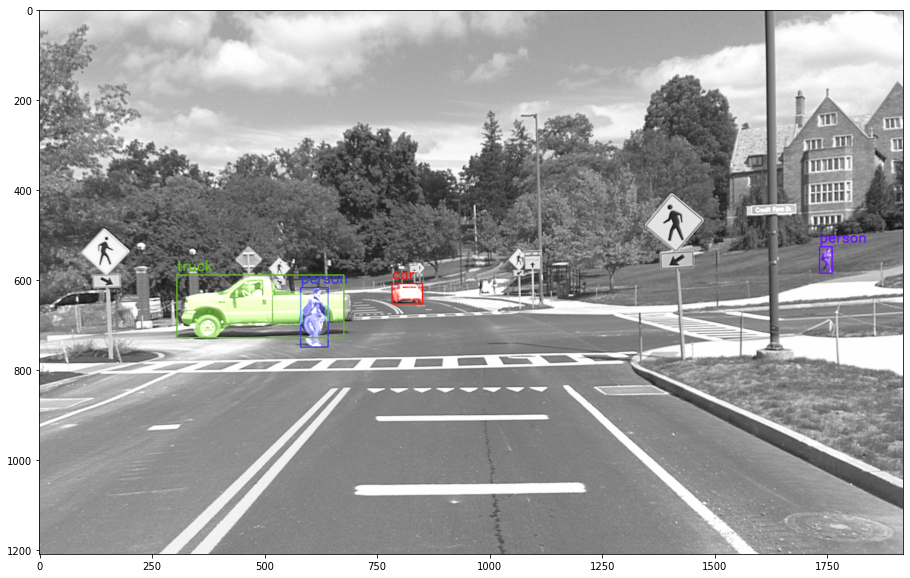

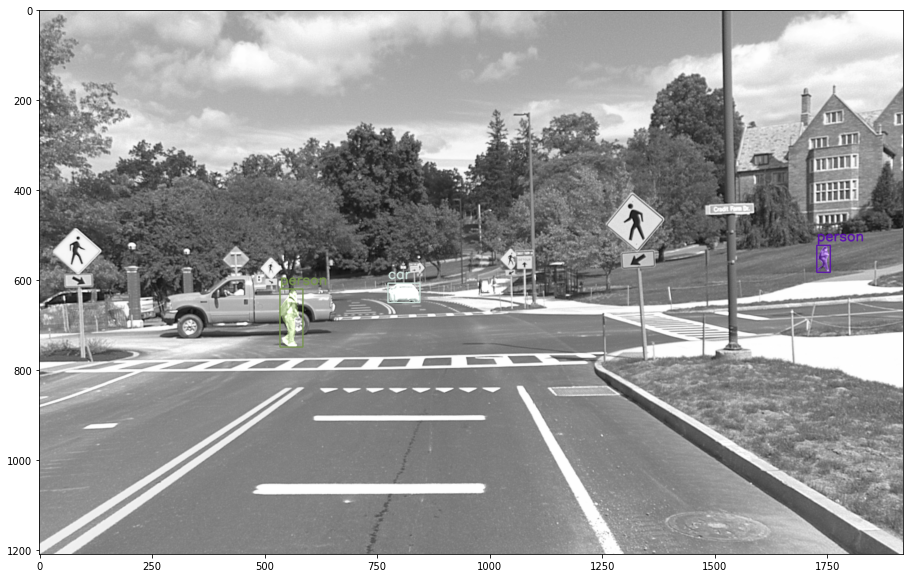

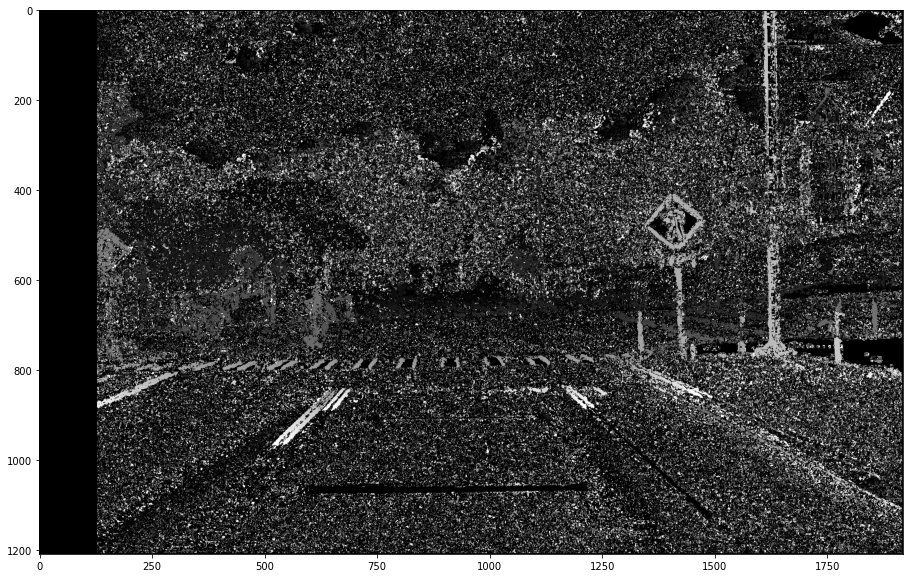

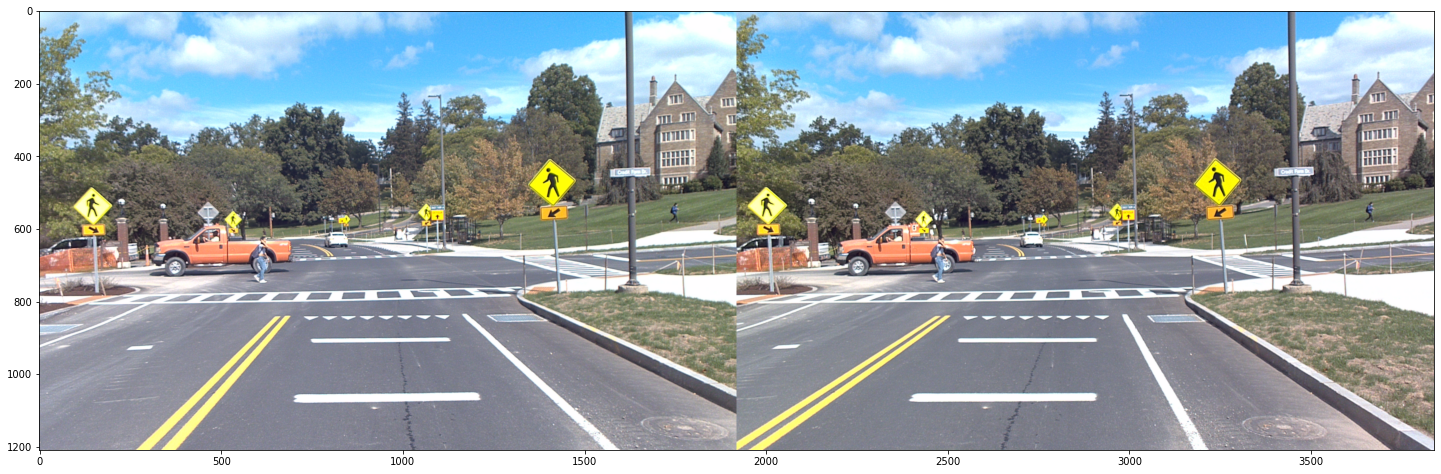

In [67]:
# pick difficulty
load_path = "./drives/easy/"
# load_path = "./drives/medium/"
# load_path = "./drives/hard/"

frames = np.load(load_path + "data.npy", allow_pickle=True) # list of dicts containing sycronized images lidar and imu
# [{"left_img": "", "right_img": "", "imu": [], "lidar": ""}, ...]
# imu is array like with
# the following structure
# [latitude, longitude, height, roll, pitch, azimuth, east_velocity, north_velocity, up_velocity]

stereo = cv2.StereoBM_create(numDisparities=128, blockSize=5) # stereo disparity class
for i, frame in enumerate(frames):
    if i != 5:
        continue
    imagesL = frame["left_img"]
    imagesR = frame["right_img"]
    lidar_file = frame["lidar"]
    imu_data = frame["imu"] 
    imgL = cv2.imread(imagesL)
    imgR = cv2.imread(imagesR)
    pcl = load_velo_scan(lidar_file, lidar_channels=5, dtype=np.float64) #Nx5 [x,y,z,i,t] np.float.64
    calibL, calibR, left_img_rect, right_img_rect, R1, R2, extrinsics, Q = rectify_image(imgL, imgR, R_rel, T_rel, instrinsicL, instrinsicR, distCoeffL, distCoeffR)
#     img_combine = line_split(np.hstack([left_img_rect, right_img_rect]))
    img_combine = np.hstack([left_img_rect, right_img_rect])
    # get image detections for left image
    masksL, boxesL, labelsL = get_detections(left_img_rect, model, device, threshold=0.9, visualize=True)
    # get image detections for right image
    masksR, boxesR, labelsR = get_detections(right_img_rect, model, device, threshold=0.9, visualize=True)
    
    plt.figure(figsize=(25, 10))
    disparity = stereo.compute(cv2.cvtColor(left_img_rect, cv2.COLOR_BGR2GRAY), cv2.cvtColor(right_img_rect, cv2.COLOR_BGR2GRAY))
    plt.imshow(disparity,'gray')
    plt.show()
    

plt.figure(figsize=(25, 10))
# plt.imshow(img_combine)
plt.imshow(cv2.cvtColor(img_combine, cv2.COLOR_BGR2RGB)) #cv2 is BGR image, matplotlib is RGB
plt.show()

# Project to Lidar: cam0

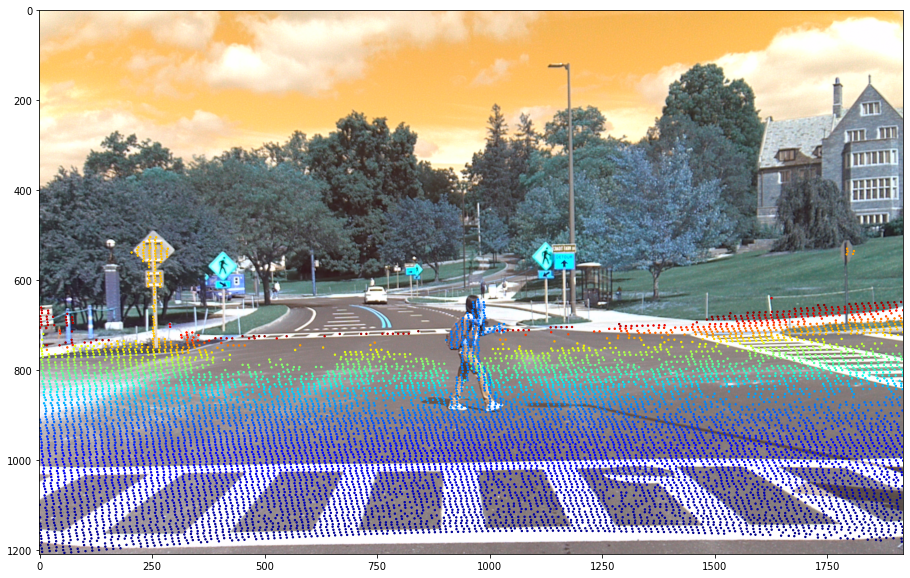

In [5]:
cmap = cm.get_cmap('jet')
# pick difficulty
load_path = "./drives/easy/"
# load_path = "./drives/medium/"
# load_path = "./drives/hard/"
frames = np.load(load_path + "data.npy", allow_pickle=True) # list of dicts containing sycronized images lidar and imu
idx = 30  # pick frame
frame = frames[idx]

imagesL = frame["left_img"]
imagesR = frame["right_img"]
lidar_file = frame["lidar"]
# imu = frame["imu"] 

imgL = plt.imread(imagesL)
imgR = plt.imread(imagesR)

img_file = imagesL
lidar_file = lidar_file



pts, intensity, times = load_pcl_from_bin5(lidar_file)

pts_cam_coord = np.dot(RotL,pts.T) + TL.reshape(-1,1) 
pts_cam_coord = np.dot(R1,pts_cam_coord )
pts_cam_coord  = pts_cam_coord.T

pts = pts[pts_cam_coord [:,2]>=0,:] 
pts_cam_coord  = pts_cam_coord [pts_cam_coord [:,2]>=0,:]
pts = pts[pts_cam_coord [:,2]<=30,:] 
pts_cam_coord  = pts_cam_coord [pts_cam_coord [:,2]<=30,:]

pixels = project_rect_to_image(pts_cam_coord, calibL)


u = pixels[:,0]
v = pixels[:,1]

idx = (u>0)*(u<1920-1)*(v>0)*(v<1208-1)
u = u[idx]
v=v[idx]
plt.figure(figsize = (120,10))
calibL, calibR, left_img_rect, right_img_rect, R1, R2, extrinsics = rectify_image(imgL, imgR, R_rel, T_rel, instrinsicL, instrinsicR, distCoeffL, distCoeffR)
# plt.imshow(left_img_rect)
plt.imshow(cv2.cvtColor(left_img_rect, cv2.COLOR_BGR2RGB)) #cv2 is BGR image, matplotlib is RGB
plt.scatter(u,v,c=pts_cam_coord[idx,2], s = 2,cmap = cmap)


# Project to Lidar: cam2

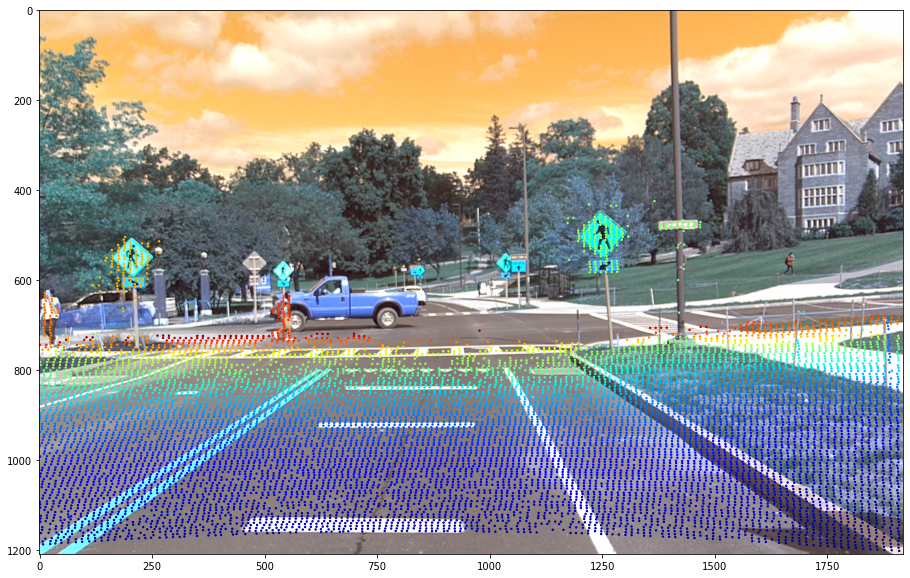

In [6]:
cmap = cm.get_cmap('jet')

# pick difficulty
load_path = "./drives/easy/"
# load_path = "./drives/medium/"
# load_path = "./drives/hard/"
frames = np.load(load_path + "data.npy", allow_pickle=True) # list of dicts containing sycronized images lidar and imu
idx = 0  # pick frame
frame = frames[idx]

imagesL = frame["left_img"]
imagesR = frame["right_img"]
lidar_file = frame["lidar"]

imgL = plt.imread(imagesL)
imgR = plt.imread(imagesR)
img_file = imagesL

pts, intensity, times = load_pcl_from_bin5(lidar_file)

pts_cam_coord = np.dot(RotL,pts.T) + TL.reshape(-1,1) 
pts_cam_coord = np.dot(R1,pts_cam_coord )
pts_cam_coord  = pts_cam_coord.T

pts = pts[pts_cam_coord [:,2]>=0,:] 
pts_cam_coord  = pts_cam_coord [pts_cam_coord [:,2]>=0,:]
pts = pts[pts_cam_coord [:,2]<=30,:] 
pts_cam_coord  = pts_cam_coord [pts_cam_coord [:,2]<=30,:]


pixels = project_rect_to_image(pts_cam_coord, calibR)


u = pixels[:,0]
v = pixels[:,1]

idx = (u>0)*(u<1920-1)*(v>0)*(v<1208-1)
u = u[idx]
v=v[idx]
plt.figure(figsize = (120,10))
calibL, calibR, left_img_rect, right_img_rect, R1, R2, extrinsics = rectify_image(imgL, imgR, R_rel, T_rel, instrinsicL, instrinsicR, distCoeffL, distCoeffR)

plt.imshow(cv2.cvtColor(right_img_rect, cv2.COLOR_BGR2RGB)) #cv2 is BGR image, matplotlib is RGB
plt.scatter(u,v,c=pts_cam_coord[idx,2], s = 2,cmap = cmap)
